### **TENSORFLOW - FUNCTION WRAPPER V1 (STRUCTURED DATA)**

<br>

Here we attempt to write the most efficient helper function possible to encapsulate the **Tensorflow 2.X & Keras API**, both Sequential & Functional.  The options are vast but we are looking for productivity of model iteration as rapidly as possible.

This first example looks at classic structured iteration using dense feed-forward layers.  We will support two possible scenarios:<br>
1) An exhaustive run through a full or fractional-factorial set of parameters, using early stopping if desired
2) Using the Keras Tuner to help us zoom in on the best parameters<br><br>

In [1]:
from itertools import product
import pandas as pd
import numpy as np

import os
import re

import tensorflow as tf
from tensorflow.keras.metrics import AUC
from keras.models import Model,save_model,load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import L1L2

from sklearn.metrics import confusion_matrix,r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import datetime as dt

import kerastuner as kt

sns.set_theme()

In [2]:
data = pd.read_csv('data_sample.csv')

In [3]:
data

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,130.81,0.609551,0.798340,0.530924,0.695092,0.0,0.417013,0.425164,0.173371,0,...,0,0,1,0,0,0,0,0,0,0
1,88.53,0.609551,0.536643,0.530924,0.405698,0.0,0.417013,0.276559,0.173371,0,...,1,0,0,0,0,0,0,0,0,0
2,76.26,0.000000,0.606126,0.000000,0.630973,0.0,0.417013,0.425164,0.268310,0,...,0,0,0,0,0,0,1,0,0,0
3,80.62,0.000000,0.536643,0.000000,0.000000,0.0,0.417013,0.276559,1.000000,0,...,0,0,0,0,0,0,0,0,0,0
4,78.02,0.000000,0.798340,0.000000,0.000000,0.0,0.417013,0.437296,0.681887,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,107.39,0.895580,0.813856,0.605892,0.630973,0.0,0.376506,0.437296,0.722705,0,...,1,0,0,0,0,0,0,0,0,0
4205,108.77,0.883142,0.624909,0.781016,1.000000,0.0,0.376506,0.557023,0.825037,0,...,0,1,0,0,0,0,0,0,0,0
4206,109.22,0.895580,0.798340,0.744581,0.695092,0.0,0.376506,0.367659,1.000000,0,...,0,0,1,0,0,0,0,0,0,0
4207,87.48,0.394160,0.753511,0.437713,0.000000,0.0,0.376506,0.276559,0.563257,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# NOTES: implement more options for regularizartion and learning rate tuning (to do)

tf_param_candidates = {
    'epochs': [5000],  # we can set the epochs to cut at fixed boundaries, or use a larger value and trust early stopping to do the rest 
    'hidden_layers': [1,2,3], #,3,4],
    'learning_rate': [5e-5,1e-4,1e-3], #1e-7,1e-6,
    'learning_rate_lift': [10,100],
    #'learning_rate_type': ['linear','exponential'],
}

tf_layer_param_candidates = {
    'hidden_neurons': [16,32,64,128], #,256,512,1024,2048,4096,8192,16384,32768], #,65536,131072], #32,64,128,256],
    'hidden_activations': ['relu','selu','tanh','sigmoid'],
    'dropouts': [0.0,0.1,0.2,0.3,0.4]
    #'kernel_regularizers': [None,'l1','l2','l1l2']
    # 'bias_regularizers': [None,'l1','l2','l1l2'],
    # 'activity_regularizers': [None,'l1','l2','l1l2'],
    # 'kernel_regularizer_weights': [0.0,1e-5,1e-4,1e-3,1e-2,0.1,0.2],
    # 'bias_regularizer_weights': [0.0,1e-5,1e-4,1e-3,1e-2,0.1,0.2],
    # 'kernel_regularizer_weights': [0.0,1e-5,1e-4,1e-3,1e-2,0.1,0.2]
}

In [37]:
def make_hyperparameters(params, layer_params, continuous = None, limit = 100):
    
    def gen_hypers(params,continuous=continuous,limit=limit):
        param_db = pd.DataFrame(product(*[params[c] for c in params]),columns=params.keys()).sample(frac=1).reset_index(drop=True)
        while len(param_db) < limit:
            param_db = param_db.append(param_db).sample(frac=1).reset_index(drop=True)
        param_db = param_db[:limit]
        if continuous is not None:
            for i in continuous:
                if i in params.keys():
                    param_db[i] = param_db.apply(lambda r: np.round(10**np.random.uniform(np.log10(min(params[i])),np.log10(max(params[i]))),10),axis=1)
        return param_db
    
    def monotonic_neurons(x):
        for i in range(1,len(x)):
            if(x[i]>x[i-1]): x[i]=x[i-1]
        return x
    
    # we could make the hidden neurons on a continuous scale 2 if we want to break from the 2^n pattern usually followed
    params_db = gen_hypers(params)
    for i in range(max(params['hidden_layers'])):
        params_layers = gen_hypers(layer_params) if i==0 else pd.concat([params_layers,gen_hypers(layer_params)],axis=1)

    for k in layer_params.keys():
        params_db = pd.concat([params_db,pd.DataFrame(params_layers.loc[:,k].apply(lambda r: list(r),axis=1),columns=[k])],axis=1)
        params_db[k] = params_db.apply(lambda r: r[k][:r['hidden_layers']],axis=1)

    params_db['hidden_neurons'] = params_db['hidden_neurons'].apply(lambda x: monotonic_neurons(x))
    
    return params_db

In [34]:
params_db = make_hyperparameters(tf_param_candidates, tf_layer_param_candidates, continuous = ['learning_rate'])
params_db

,epochs,hidden_layers,learning_rate,learning_rate_lift,hidden_neurons,hidden_activations,dropouts
0,5000,1,0.000167,100,[16],[tanh],[0.1]
1,5000,1,0.000245,100,[16],[selu],[0.1]
2,5000,1,0.000929,10,[64],[sigmoid],[0.2]
3,5000,1,0.000143,100,[64],[relu],[0.4]
4,5000,2,0.000116,10,"[32, 32]","[sigmoid, relu]","[0.1, 0.4]"
...,...,...,...,...,...,...,...
95,5000,2,0.000084,10,"[128, 32]","[relu, tanh]","[0.4, 0.3]"
96,5000,3,0.000111,10,"[32, 16, 16]","[selu, selu, relu]","[0.1, 0.0, 0.2]"
97,5000,2,0.000804,10,"[16, 16]","[selu, selu]","[0.4, 0.1]"
98,5000,1,0.000105,100,[32],[sigmoid],[0.2]


In [104]:
def tf_wrapper(data,type='regressor',bags=3,shuffle=True,return_model=False,target='y',test_frac=0.1,loss='mse',eval_metrics='mse',epochs=100,hidden_layers=1,
               learning_rate=1e-5,learning_rate_lift=10,hidden_neurons=[32],hidden_activations=['relu'],dropouts=[0.0],kernel_regularizers=None,bias_regularizers=None,
               activity_regularizers=None,kernel_regularizer_weights=None,bias_regularizer_weights=None,activity_regularizer_weights=None,output_neurons=1,
               output_activation=None,verbose=1):
    data = data.loc[:,:].copy()
    
    for i in range(bags):
        if shuffle is True: data = data.sample(frac=1)
        x_val = data.iloc[:int(len(data)*test_frac),:]
        y_val = x_val.pop(target)
        x_train = data.iloc[int(len(data)*test_frac):,:]
        y_train = x_train.pop(target)

        lr_scheduler = LearningRateScheduler(
            lambda epoch: learning_rate * 10**(np.log10(learning_rate_lift)*epoch/epochs)
        )

        # see if we can make this better on our own
        # reduce_lr = ReduceLROnPlateau(
        #     monitor = 'val_loss',
        #     factor = 0.2,
        #     patience = 5,
        #     mode = 'min',
        #     cooldown = 200,
        #     verbose = 0
        # )
        
        early_stop = EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=6,
            verbose=0,
            mode='min',
            baseline=None,
            restore_best_weights=True
        )
        
        # checkpoint = ModelCheckpoint(
        #     os.path.join(model_dir,model_path)+'.h5',
        #     monitor = 'val_r_square',
        #     verbose = 0,
        #     mode = 'max', 
        #     save_best_only = True
        # )

        # build our network using the functional API
        input_layer = tf.keras.Input(shape=x_train.iloc[0,:].shape)
        x = input_layer
        for l in range(hidden_layers):
            x = tf.keras.layers.Dense(hidden_neurons, activation = hidden_activations[l])(x)
            x = tf.keras.layers.Dropout(dropouts[l])(x)
        output_layer = tf.keras.layers.Dense(output_neurons, activation = output_activation)(x)
        model = Model(inputs = input_layer, outputs = output_layer)

        model.compile(
            loss = loss,
            optimizer = tf.keras.optimizers.Adam(),
            metrics = eval_metrics
        )

        if return_model is True: return model

        history = model.fit(
            x_train,
            y_train,
            epochs = epochs,
            verbose = verbose,
            validation_data = (x_val,y_val),
            callbacks = [lr_scheduler,early_stop] #,reduce_lr,checkpoint]
        )
            
        y_pred_train = model.predict(x_train, verbose = verbose).squeeze()
        y_pred_val = model.predict(x_val, verbose = verbose).squeeze()
        r2_train = r2_score(y_train, y_pred_train)
        r2_val = r2_score(y_val, y_pred_val)
        
        history = pd.DataFrame.from_dict(history.history).reset_index()
        history.columns = ['epoch']+list(history.columns)[1:]
        history['epoch'] = history['epoch']+1
        history['max_epochs'] = epochs
        history['rounds'] = bags
        history['round'] = i
        history['lr_start'] = learning_rate
        history['lr_end'] = learning_rate*learning_rate_lift
        history['lr_lift'] = learning_rate_lift
        history['optimizer'] = 'adam'
        history['timestamp'] = dt.strftime(dt.now(),'%Y-%m-%d %H:%M:%S')
        history['layer_details'] = str([hidden_neurons,hidden_activations,dropouts])
        history['train_r2'] = r2_train
        history['val_r2'] = r2_val
        
        history_all = history if i==0 else history_all.append(history) 
    return history_all.reset_index(drop=True)

#         try:
#             history_store = pd.read_csv(model_dir+'/regression_mercedezbenz_history.csv')
#             history = history_store.append(history)
#         except:
#             pass

#         history.to_csv(model_dir+'/regression_mercedezbenz_history.csv',index=False)

#         print('model returned an r2 of '+str(r2))
#         if return_vals is True:
#             return model_best,history,r2

In [72]:
for i in range(len(params_db)):
    params = params_db.iloc[i,:].to_dict()
    #print(i,params,'running...')
    hist = tf_wrapper(data,bags=1,verbose=0,loss='mse',test_frac=0.1,eval_metrics=[tf.keras.metrics.RootMeanSquaredError()],**params)
    hist['permutation'] = i+1
    if i==0:
        model_history = hist
    else:
        model_history = pd.read_csv('model_history_tf2.csv').append(hist).reset_index(drop=True)
    model_history.to_csv('model_history_tf2.csv',index=False)

In [73]:
model_history.head()

,epoch,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,lr,max_epochs,rounds,round,lr_start,lr_end,lr_lift,optimizer,timestamp,layer_details,train_r2,val_r2,permutation
0,1,7055.556641,83.997368,5562.105469,74.579529,0.000789,5000,1,0,0.000789,0.078875,100,adam,2022-09-29 15:58:20,"[[128, 128, 128], ['relu', 'relu', 'tanh'], [0...",-0.004125,-0.000102,1
1,2,4897.325195,69.980888,4011.690674,63.337910,0.000789,5000,1,0,0.000789,0.078875,100,adam,2022-09-29 15:58:20,"[[128, 128, 128], ['relu', 'relu', 'tanh'], [0...",-0.004125,-0.000102,1
2,3,3524.802002,59.370049,2843.448730,53.323997,0.000790,5000,1,0,0.000789,0.078875,100,adam,2022-09-29 15:58:20,"[[128, 128, 128], ['relu', 'relu', 'tanh'], [0...",-0.004125,-0.000102,1
3,4,2495.806396,49.958046,1975.529663,44.446930,0.000791,5000,1,0,0.000789,0.078875,100,adam,2022-09-29 15:58:20,"[[128, 128, 128], ['relu', 'relu', 'tanh'], [0...",-0.004125,-0.000102,1
4,5,1730.808838,41.602989,1345.936523,36.687008,0.000792,5000,1,0,0.000789,0.078875,100,adam,2022-09-29 15:58:20,"[[128, 128, 128], ['relu', 'relu', 'tanh'], [0...",-0.004125,-0.000102,1


In [20]:
def clean_model_history(hist,chart_period=1):
    hist_new = hist[['permutation','max_epochs','lr_start','lr_end','lr_lift','optimizer','layer_details','round','epoch']]
    hist_new = hist_new.groupby(['permutation','max_epochs','lr_start','lr_end','lr_lift','optimizer','layer_details','round']).max().reset_index()
    hist_new = hist_new[['permutation','max_epochs','lr_start','lr_end','lr_lift','optimizer','layer_details','epoch']]
    hist_new = hist_new.groupby(['permutation','max_epochs','lr_start','lr_end','lr_lift','optimizer','layer_details']).min().reset_index()
    hist_new.columns = list(hist_new.columns)[:-1]+['epoch_cutoff']
    hist_new = hist.merge(hist_new,how='left',on=list(hist_new.columns)[:-1],sort=False)
    hist_new = hist_new[hist_new['epoch']<=hist_new['epoch_cutoff']]
    chart_data = hist_new[['permutation','epoch','root_mean_squared_error','val_root_mean_squared_error','max_epochs','lr_start','lr_end','lr_lift','optimizer','layer_details','train_r2','val_r2']]
    chart_data = chart_data.groupby(['permutation','epoch','max_epochs','lr_start','lr_end','lr_lift','optimizer','layer_details']).median().reset_index()
    table_data = chart_data[['max_epochs','epoch','lr_start','lr_end','lr_lift','optimizer','layer_details','train_r2','val_r2','root_mean_squared_error','val_root_mean_squared_error']]
    table_data1 = table_data.groupby(['max_epochs','lr_start','lr_end','lr_lift','optimizer','layer_details']).max().reset_index()
    table_data2 = table_data.groupby(['max_epochs','lr_start','lr_end','lr_lift','optimizer','layer_details']).min().reset_index()
    table_data = pd.concat([table_data1.iloc[:,:-2],table_data2[['root_mean_squared_error','val_root_mean_squared_error']]],axis=1).sort_values(by='val_r2',ascending=False).reset_index(drop=True)
    
    if chart_period > 1:
        #r = np.int(np.log10(chart_period))
        #chart_data['log_epoch'] = chart_data['epoch'].apply(lambda x: np.int(chart_period*np.round(np.log10(x),r)))
        chart_data = chart_data[(chart_data['epoch']%chart_period == 0) | (chart_data['epoch'] == 1)].reset_index(drop=True)
        #del chart_data['log_epoch']

    return (chart_data,table_data)

In [21]:
(chart_data,table_data) = clean_model_history(model_history,chart_period=1)

In [59]:
chart_data['lr_group'] = chart_data['lr_start'].apply(lambda r: max(1,len(set([c for c in chart_data['lr_start'] if c < r]))//11))
lr_groups = chart_data['lr_group'].unique()
lr_groups.sort()

In [60]:
chart_data.sort_values(by='lr_group',ascending=False)

,permutation,epoch,max_epochs,lr_start,lr_end,lr_lift,optimizer,layer_details,root_mean_squared_error,val_root_mean_squared_error,train_r2,val_r2,lr_group
1804,29,9,5000,0.000978,0.009779,10,adam,"[[512, 512, 256], ['selu', 'tanh', 'sigmoid'],...",15.249390,13.433606,-1.175695e-03,-0.000019,9
1806,29,11,5000,0.000978,0.009779,10,adam,"[[512, 512, 256], ['selu', 'tanh', 'sigmoid'],...",13.189292,12.130466,-1.175695e-03,-0.000019,9
1813,29,18,5000,0.000978,0.009779,10,adam,"[[512, 512, 256], ['selu', 'tanh', 'sigmoid'],...",12.756992,11.965096,-1.175695e-03,-0.000019,9
1812,29,17,5000,0.000978,0.009779,10,adam,"[[512, 512, 256], ['selu', 'tanh', 'sigmoid'],...",12.755543,11.963380,-1.175695e-03,-0.000019,9
1811,29,16,5000,0.000978,0.009779,10,adam,"[[512, 512, 256], ['selu', 'tanh', 'sigmoid'],...",12.756876,11.960688,-1.175695e-03,-0.000019,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5964,73,217,5000,0.000077,0.007659,100,adam,"[[256, 32, 32], ['sigmoid', 'selu', 'sigmoid']...",52.184238,52.560024,-1.593709e-07,-0.001583,1
5965,73,218,5000,0.000077,0.007659,100,adam,"[[256, 32, 32], ['sigmoid', 'selu', 'sigmoid']...",51.956051,52.331665,-1.593709e-07,-0.001583,1
5966,73,219,5000,0.000077,0.007659,100,adam,"[[256, 32, 32], ['sigmoid', 'selu', 'sigmoid']...",51.727741,52.103046,-1.593709e-07,-0.001583,1
5967,73,220,5000,0.000077,0.007659,100,adam,"[[256, 32, 32], ['sigmoid', 'selu', 'sigmoid']...",51.499313,51.874264,-1.593709e-07,-0.001583,1


In [26]:
table_data.sort_values(by='val_r2',ascending=False)

,max_epochs,lr_start,lr_end,lr_lift,optimizer,layer_details,epoch,train_r2,val_r2,root_mean_squared_error,val_root_mean_squared_error
0,5000,0.000050,0.005004,100,adam,"[[32768], ['tanh'], [0.2]]",31,0.567694,0.655056,8.440680,7.015815
1,5000,0.000271,0.002706,10,adam,"[[16384], ['relu'], [0.1]]",25,0.587551,0.652049,8.293273,6.745557
2,5000,0.000174,0.001741,10,adam,"[[256, 256], ['relu', 'relu'], [0.2, 0.3]]",21,0.550031,0.644641,11.032131,7.215759
3,5000,0.000164,0.001642,10,adam,"[[256, 256], ['relu', 'selu'], [0.4, 0.0]]",45,0.583479,0.643858,9.138498,7.160320
4,5000,0.000526,0.052575,100,adam,"[[512, 256], ['relu', 'tanh'], [0.3, 0.2]]",31,0.571572,0.640345,8.953370,7.408438
...,...,...,...,...,...,...,...,...,...,...,...
95,5000,0.000092,0.009250,100,adam,"[[16, 16, 16], ['tanh', 'tanh', 'sigmoid'], [0...",538,-0.075478,-0.069480,22.128969,12.493325
96,5000,0.000185,0.018516,100,adam,"[[16384, 16, 16], ['relu', 'tanh', 'tanh'], [0...",296,-0.082879,-0.108183,22.261250,13.368921
97,5000,0.000551,0.055083,100,adam,"[[16384, 16], ['sigmoid', 'tanh'], [0.4, 0.4]]",124,-0.089394,-0.114968,22.508661,13.738742
98,5000,0.000231,0.002313,10,adam,"[[32, 16, 16], ['relu', 'relu', 'relu'], [0.3,...",21,-0.278854,-0.391844,32.576843,13.949430


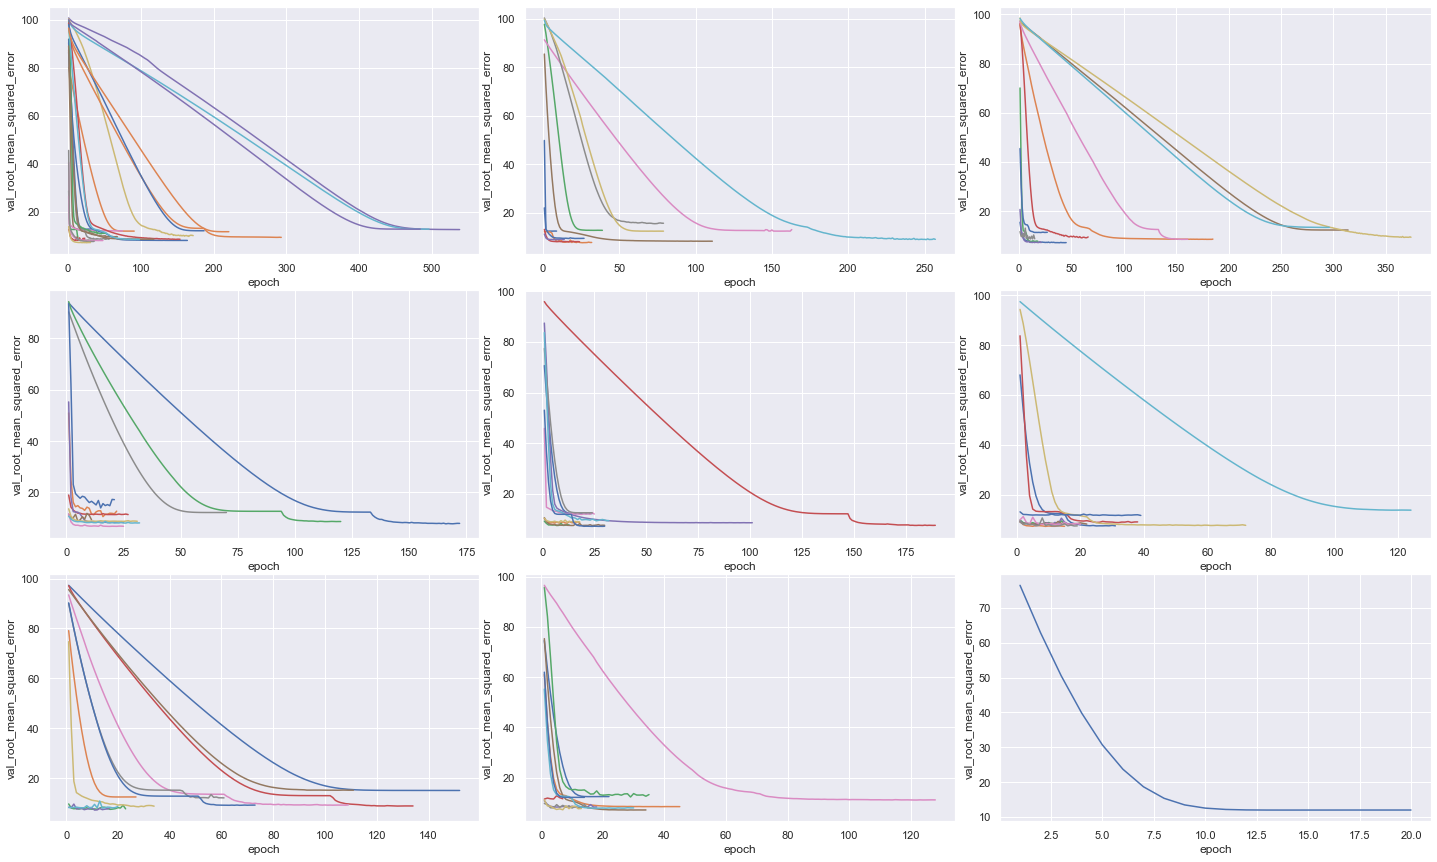

In [80]:
(d1,d2) = (3,3)
fig,axes = plt.subplots(d1, d2, figsize=(20,12))
fig.tight_layout()
fig_metrics = ['val_root_mean_squared_error']
for i,j in enumerate(lr_groups):
    data1 = chart_data[chart_data['lr_group']==j]
    for p in set(data1['permutation']):
        data2 = data1[data1['permutation']==p]
        s = sns.lineplot(ax=axes[i//3,i%3], x = data2['epoch'], y = data2['val_root_mean_squared_error'])
        #s.set_ylim(bottom=7,top=10);

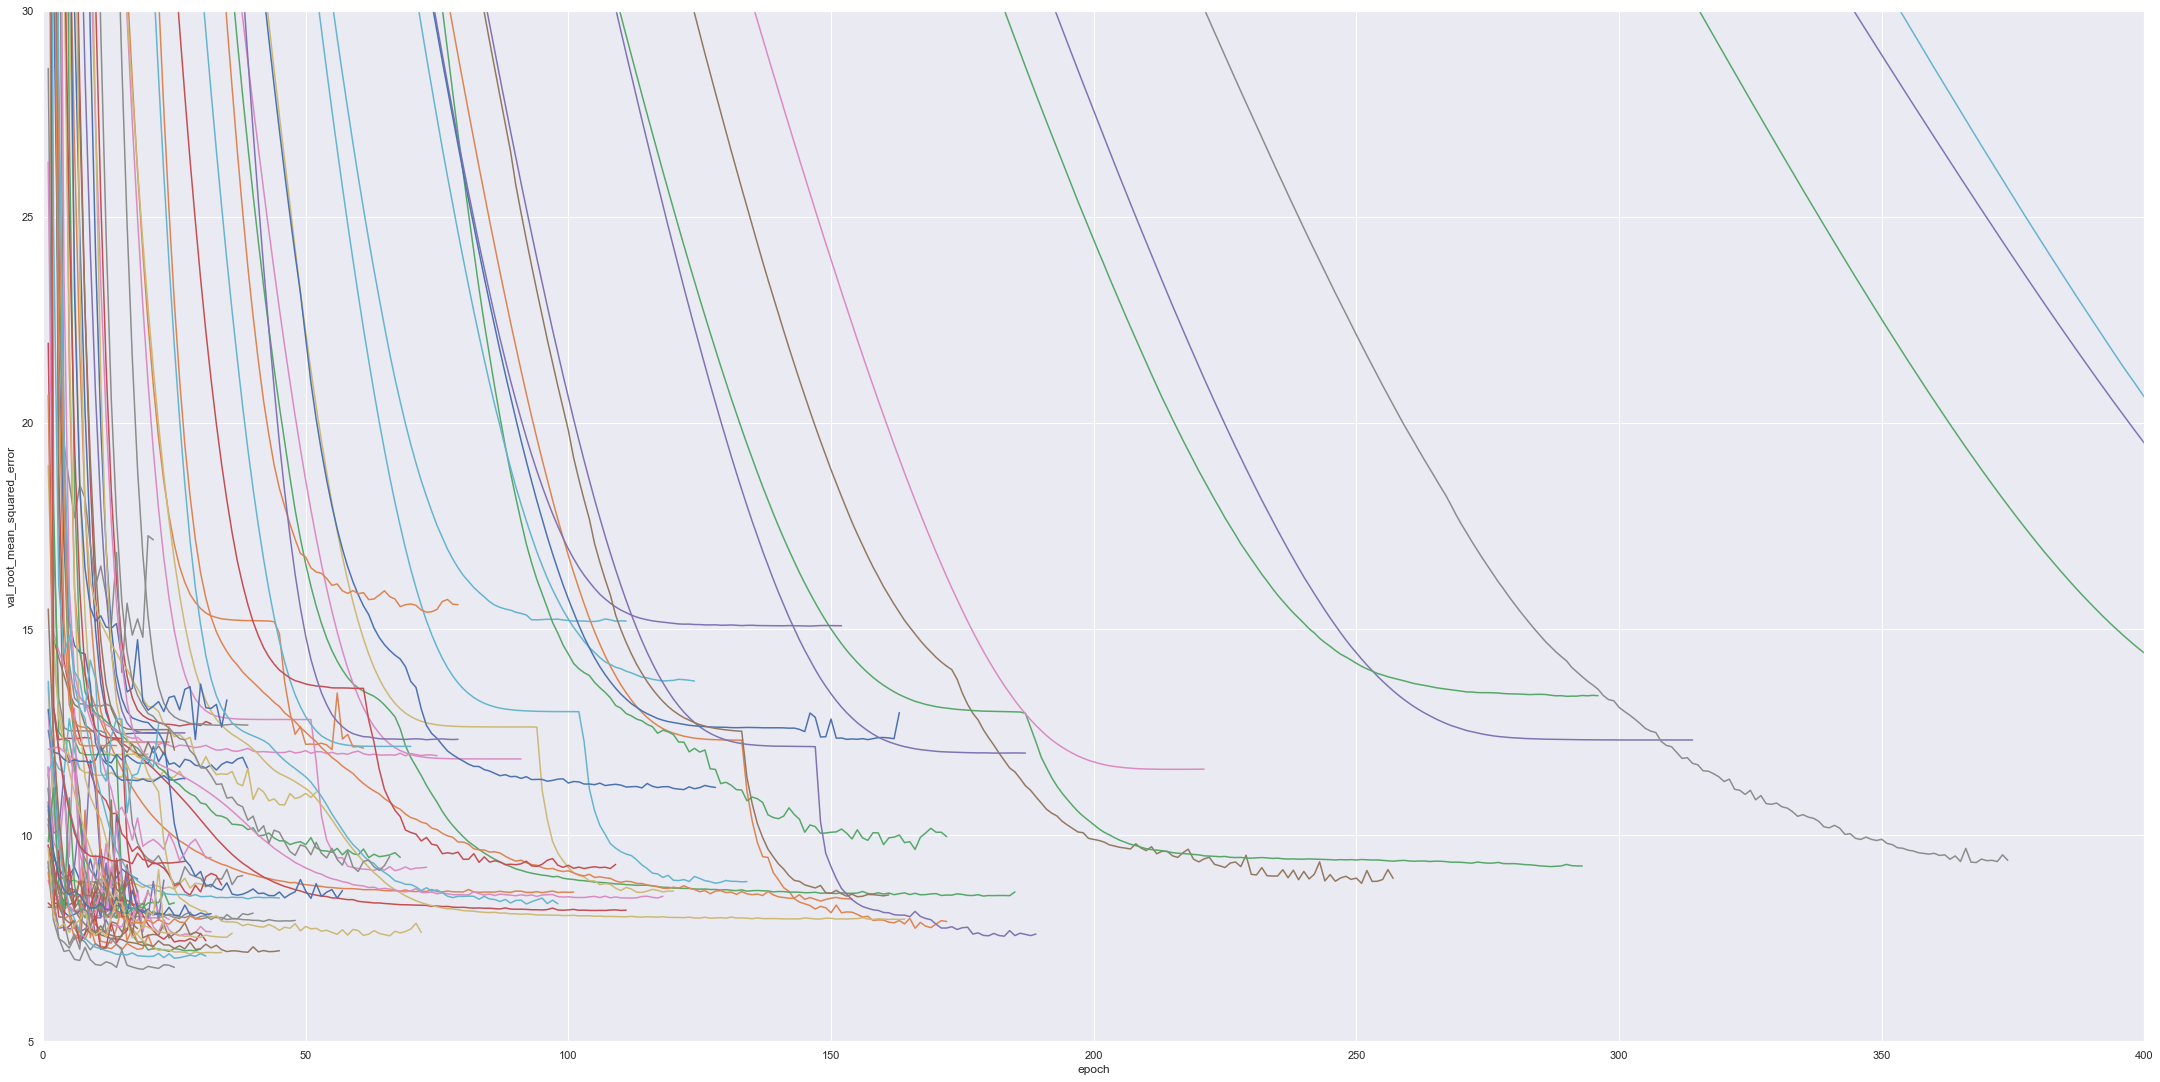

In [71]:
(d1,d2) = (1,1)
fig,axes = plt.subplots(d1, d2, figsize=(30,15))
fig.tight_layout()
for i,j in enumerate(chart_data['permutation'].unique()):
    data = chart_data[chart_data['permutation']==j]
    s = sns.lineplot(ax=axes, x = data['epoch'], y = data['val_root_mean_squared_error'])
    s.set_xlim(left=0,right=400);
    s.set_ylim(bottom=5,top=30);

An initial conclusion here is that models trained more aggressively are reaching better loss scores before overfitting.  They reach the overfitting/loss divergnce point faster, but by the time they get there, we have an improved "valley" of loss relative to the slower trained examples

<br>

**KERAS TUNER**

Let's take a look at putting the same hyperparameters into the Keras tuner to draw some conclusions.  This will train each model partially with some 'test epochs', to estimte which one will perform best.  We can compare these results to our work above to see what can be achieved:

In [6]:
def get_neuron_map(layers=1,rows=150,ensure_monotonic=True):
    n = tf_layer_param_candidates['hidden_neurons']
    max_hidden_layers = layers
    neuron_grid = pd.DataFrame(product(*[n for i in range(max_hidden_layers)]),columns=['layer'+str(i+1) for i in range(max_hidden_layers)])
    cols = list(neuron_grid.columns)
    if ensure_monotonic is True:
        for i in range(max_hidden_layers-1):
            neuron_grid = neuron_grid[neuron_grid[cols[i]]>=neuron_grid[cols[i+1]]]
    return np.array(neuron_grid.sample(frac=1).reset_index(drop=True)[:rows]) #.reset_index(drop=True)

In [7]:
neuron_map = get_neuron_map(layers=4)

<br>This architecture allows the number of hidden layers to be a hyperparameter in itself.  By having the layer number as the first parameter, and selecting the numbers of hidden heurons in advance, we can then conditionally add layers, whichg use the pre-selected neurons from our map.<br><br>
The neuron map will, by default, prevent successive layers from having more neurons than the previous (monotonic decreasing).  This is optional.<br><br>
**Note:** the tuner will often crash for large numbers of hidden neurons and many layers, due to memory issues.  It is best to try these values only selectively or tune them with the code above.

In [8]:
def model_builder_1(hp):
    hp_layers = hp.Choice('layers',tf_param_candidates['hidden_layers'])
    hp_neurons = hp.Choice('neurons',list(range(len(neuron_map))))
    hp_lr = hp.Choice('lr',tf_param_candidates['learning_rate'])
                           
    input_layer = tf.keras.Input(shape=x_train.iloc[0,:].shape)
    x = input_layer
    x = tf.keras.layers.Dense(neuron_map[hp_neurons][0], activation = 'relu')(x)
    
    with hp.conditional_scope('layers',[2,3]):
        if hp_layers >= 2:
            x = tf.keras.layers.Dense(neuron_map[hp_neurons][1], activation = 'relu')(x)
    with hp.conditional_scope('layers',[3]):
        if hp_layers >= 3:
            x = tf.keras.layers.Dense(neuron_map[hp_neurons][2], activation = 'relu')(x)
    
    output_layer = tf.keras.layers.Dense(1)(x)
    model = Model(inputs = input_layer, outputs = output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
                loss='mse',
                metrics=['mae','mse'])
    return model

In [9]:
test_frac = 0.1
target = 'y'
x_val = data.iloc[:int(len(data)*test_frac),:]
y_val = x_val.pop(target)
x_train = data.iloc[int(len(data)*test_frac):,:]
y_train = x_train.pop(target)

In [12]:
tuner_1 = kt.Hyperband(
    model_builder_1,
    objective = 'val_mse',
    overwrite = True,
    max_epochs = 100,
    factor = 3,
    directory = 'keras_tuner',
    project_name = 'model_builder_1'
)

In [13]:
test_frac = 0.1
target = 'y'
x_val = data.iloc[:int(len(data)*test_frac),:]
y_val = x_val.pop(target)
x_train = data.iloc[int(len(data)*test_frac):,:]
y_train = x_train.pop(target)

perf_log = []

class CatchLog(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        perf_log.append(logs)

stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [38]:
tuner_1.search(x_train, y_train, epochs = 80, validation_data = (x_val,y_val), callbacks = [stop_early], verbose = 1)

best_hps_1 = tuner_1.get_best_hyperparameters(num_trials=1)[0]

In [23]:
print(f"""The hyperparameter search is complete.
Layers: {best_hps_1.get('layers')}.
Neurons: {neuron_map[best_hps_1.get('neurons')][:(best_hps_1.get('layers'))]}.
Learning Rate: {best_hps_1.get('lr')}.""")

The hyperparameter search is complete.
Layers: 1.
Neurons: [128].
Learning Rate: 0.001.
